Visualization of mean counts/mean lengths

In [1]:
%run ../scripts/notebook_settings_lean.py
from horizonplot import horizonplot

In [2]:
#Functions to generate the stacked area plot df

#Should be easily extendable to multiple paintings by repeating the loop
def length_to_windows(length_df, window_size=100000):
    pops = sorted(length_df["pop"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.paint_length)//window_size
            if x == 0:
                overall_dict[row["pop"]][i] += int(row.paint_length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["pop"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["pop"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["pop"]][i+x] += int(row.paint_length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def generate_spot_df(single_p_df, map_dict):
    single_p_df["pop"] = single_p_df["paint"].map(map_dict)
    shift_spots = (single_p_df["pop"] != single_p_df["pop"].shift())
    #df based on this subset
    spot_df = single_p_df.loc[shift_spots].copy()
    #Finding the start of the next painting, by removing the first pos and adding the last snp.
    #And then calculating the difference.
    spot_df["paint_length"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-spot_df["pos"].values)
    spot_df["end_pos"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-1)
    return spot_df

def create_paint_df_lengths(paintfile, idfile):
    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    
    map_dict = {}
    for i, row in idfile.iterrows():
        map_dict[row.ID_index*2+1] = row["pop"]
        map_dict[row.ID_index*2+2] = row["pop"]

    df_l = []
    f = open(paintfile, "r")
    ad_lines = f.readlines()
    ind = ""
    hap = ""
    for p_num in range(1, len(ad_lines)):
        l = ad_lines[p_num].strip().split(" ")
        if l[0] == "HAP":
            ind = l[2]
            if hap == 1:
                hap = 2
            else:
                hap = 1
        else:
            paint_line = l[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            spot_df["individual"] = ind
            spot_df["haplotype"] = hap
            df_l.append(spot_df)
    all_df = pd.concat(df_l)
    return all_df

In [31]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"

os.makedirs("../steps/paint_summary/", exist_ok=True)
chrom_list = [] #["8", "X"] # ["X"]
window_length = 100000
df_l = []
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in sorted(idfile["pop"].unique()):
        print(population)
        pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "chr{}_8_cluster_large/{}_chr{}_8_cluster_large/chr{}.samples.out"\
                        .format(chrom, population, chrom, chrom)
        length_df = create_paint_df_lengths(pop_path, idfile)
        length_df["chrom"] = chrom
        length_df["C_origin"] = population
        df_l.append(length_df)
#df_lengths = pd.concat(df_l)

In [32]:
#df_lengths.to_csv("../steps/paint_summary/"+"paint_lengths_8_cluster.txt", sep=" ", index=False)
df_lengths = pd.read_csv("../steps/paint_summary/"+"paint_lengths_8_cluster.txt", sep=" ")

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
    else:
        mapping[row.PGDP_ID] = row.Origin

In [34]:
df_lengths["population"] = df_lengths["individual"].map(mapping)
df_lengths["chrom"] = ["chr{}".format(x) if str(x)[0] != "c" else x for x in df_lengths.chrom] # Some are read as int

In [35]:
df_lengths

,pos,paint,pop,paint_length,end_pos,individual,haplotype,chrom,C_origin,population
0,4254,99,anubis_tanzania,48472,52725,PD_0721,1,chr8,anubis_ethiopia,"Gog Woreda, Gambella region, Ethiopia"
1,52726,74,papio,272,52997,PD_0721,1,chr8,anubis_ethiopia,"Gog Woreda, Gambella region, Ethiopia"
2,52998,30,anubis_tanzania,18453,71450,PD_0721,1,chr8,anubis_ethiopia,"Gog Woreda, Gambella region, Ethiopia"
3,71451,2,cyno_central,793,72243,PD_0721,1,chr8,anubis_ethiopia,"Gog Woreda, Gambella region, Ethiopia"
4,72244,39,anubis_tanzania,19107,91350,PD_0721,1,chr8,anubis_ethiopia,"Gog Woreda, Gambella region, Ethiopia"
...,...,...,...,...,...,...,...,...,...,...
36314422,143161356,114,cyno_western,142626,143303981,PD_0695,2,chrX,ursinus,"Dendro Park, Zambia"
36314423,143303982,122,anubis_tanzania,122567,143426548,PD_0695,2,chrX,ursinus,"Dendro Park, Zambia"
36314424,143426549,114,cyno_western,235954,143662502,PD_0695,2,chrX,ursinus,"Dendro Park, Zambia"
36314425,143662503,92,anubis_tanzania,26251,143688753,PD_0695,2,chrX,ursinus,"Dendro Park, Zambia"


In [36]:
df_total_stats = df_lengths.groupby(["individual", "C_origin", "chrom"]).mean().reset_index()
df_total_stats["Median Fragment"] = df_lengths.groupby(["individual", "C_origin", "chrom"]).median().reset_index().paint_length

Text(0.5, 0, 'Mean Fragment')

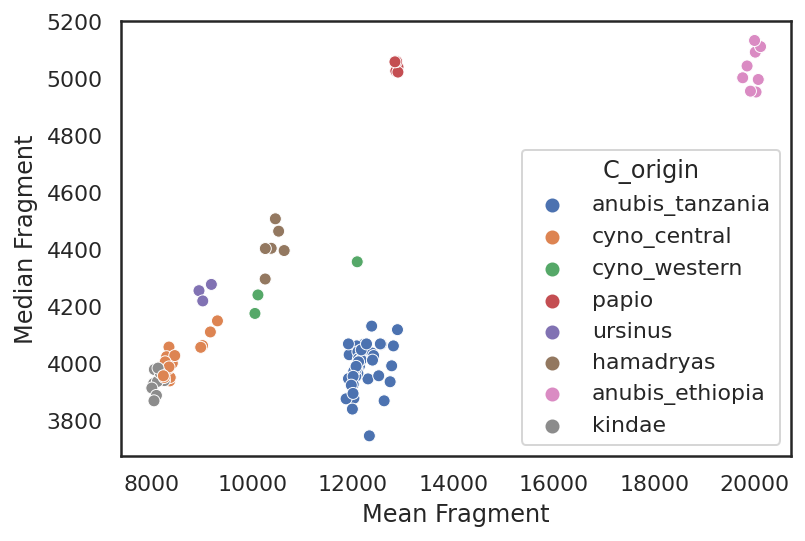

In [37]:
df_8 = df_total_stats.loc[df_total_stats.chrom=="chr8"]
g = sns.scatterplot(data=df_8, x="paint_length", y="Median Fragment", hue="C_origin")
g.set_xlabel("Mean Fragment")

Text(0.5, 0, 'Mean Fragment')

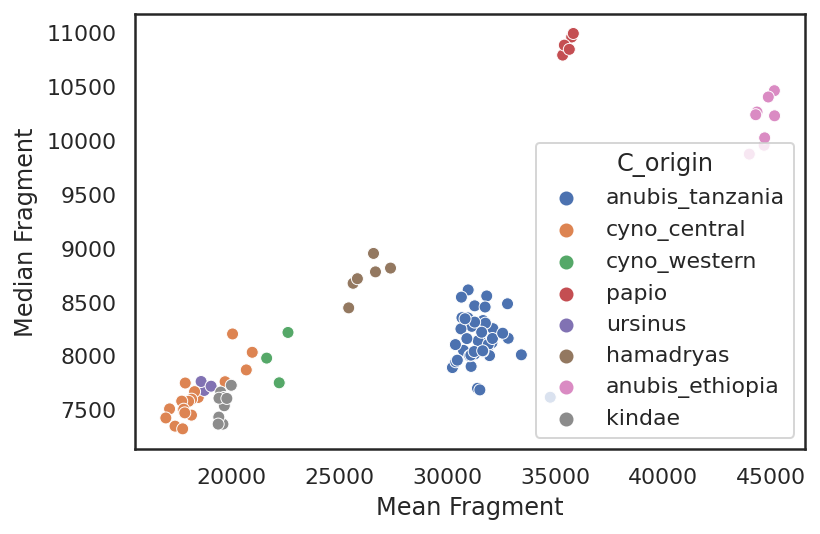

In [38]:
df_X = df_total_stats.loc[df_total_stats.chrom=="chrX"]
g = sns.scatterplot(data=df_X, x="paint_length", y="Median Fragment", hue="C_origin")
g.set_xlabel("Mean Fragment")

In [39]:
df_length_stats = df_lengths.groupby(["individual", "pop", "C_origin", "chrom"]).sum().reset_index()
df_length_stats["Ancestry Counts"] = (df_lengths.groupby(["individual", "pop", "C_origin", "chrom"]).count().reset_index()).paint_length
df_length_stats["Mean Fragment"] = (df_lengths.groupby(["individual", "pop", "C_origin", "chrom"]).mean().reset_index()).paint_length

In [40]:
groups = df_length_stats.groupby(["individual", "chrom"])
s = groups.transform("sum")
df_length_stats["Ancestry Percentage"] = df_length_stats["paint_length"]/s["paint_length"]
df_length_stats["Fragment Percentage"] = df_length_stats["Ancestry Counts"]/s["Ancestry Counts"]

In [41]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
c_mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
    else:
        mapping[row.PGDP_ID] = row.Origin

In [42]:
c_mapping = {}
for donor in idfile["pop"].unique():
    IDs = idfile.loc[idfile["pop"] == donor].PGDP_ID.unique()
    c_mapping[donor] = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(IDs)].C_origin.unique()[0]

In [43]:
c_mapping

{'cyno_central': 'Cynocephalus, Central Tanzania',
 'kindae': 'Kindae, Zambia',
 'hamadryas': 'Hamadryas, Ethiopia',
 'anubis_tanzania': 'Anubis, Tanzania',
 'cyno_western': 'Cynocephalus, Western Tanzania',
 'papio': 'Papio, Senegal',
 'ursinus': 'Ursinus, Zambia',
 'anubis_ethiopia': 'Anubis, Ethiopia'}

In [44]:
df_length_stats["population"] = df_length_stats["individual"].map(mapping)
df_length_stats["Population, Donor"] = df_length_stats["pop"].map(c_mapping)
df_length_stats["Population, Recipient"] = df_length_stats["C_origin"].map(c_mapping)
df_length_stats = df_length_stats.sort_values(["population", "individual", "pop", "chrom"])
df_length_stats["Ancestry Fragment Ratio"] = df_length_stats["Ancestry Percentage"]/df_length_stats["Fragment Percentage"]

In [45]:
mycols = sns.color_palette(["#BEE39C", "#1F681F", "#FFE7AF",
                            "#FFD062", "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])
name_order = sorted(df_length_stats["Population, Donor"].unique())
color_dir = {}
for i in range(len(name_order)):
    color_dir[name_order[i]] = mycols[i]
# This order of color is based on the alphabetical ordering of the 14 clusters
mycols_cmap = ListedColormap(mycols.as_hex())
mycols

[(0.7450980392156863, 0.8901960784313725, 0.611764705882353),
 (0.12156862745098039, 0.40784313725490196, 0.12156862745098039),
 (1.0, 0.9058823529411765, 0.6862745098039216),
 (1.0, 0.8156862745098039, 0.3843137254901961),
 (0.6196078431372549, 0.6784313725490196, 0.6980392156862745),
 (0.1450980392156863, 0.5490196078431373, 0.7568627450980392),
 (0.9176470588235294, 0.2, 0.1411764705882353),
 (0.7529411764705882, 0.42745098039215684, 0.20392156862745098)]

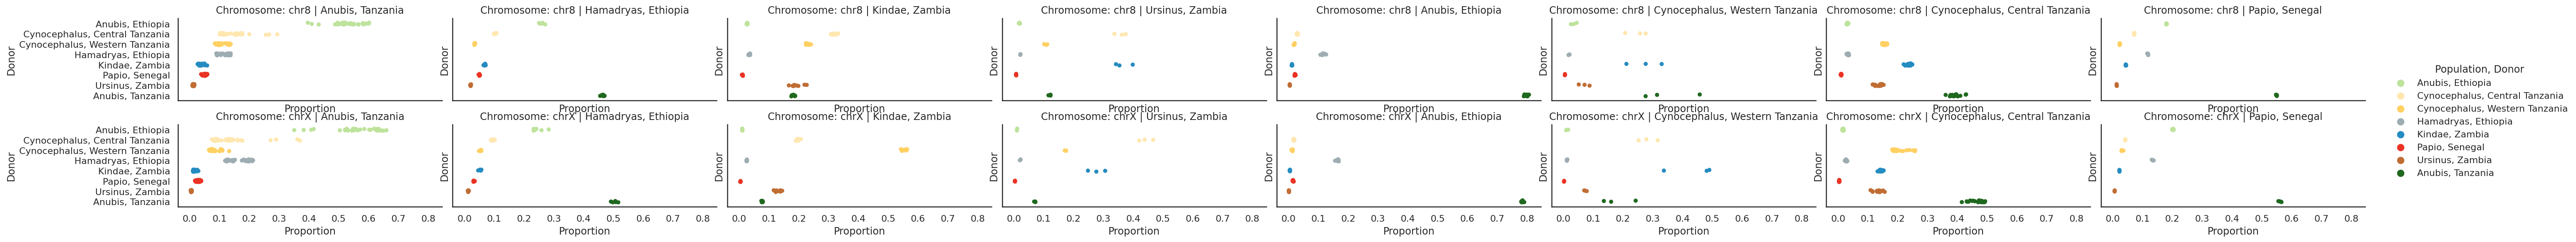

In [46]:
g = sns.catplot(data=df_length_stats, x="Ancestry Percentage", y="Population, Donor", hue="Population, Donor", kind="strip", orient="h",
                height=2, aspect=2.5, col="Population, Recipient", row="chrom", jitter=True, palette=color_dir)
for ax in g.axes.flat:
    ax.set_xlabel("Proportion") #  y labels
    ax.set_ylabel("Donor") # X labels
    plt.setp(ax.texts, rotation="0") # vandrette row labels
g.set_titles(row_template = 'Chromosome: {row_name}', col_template = '{col_name}')

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the fut

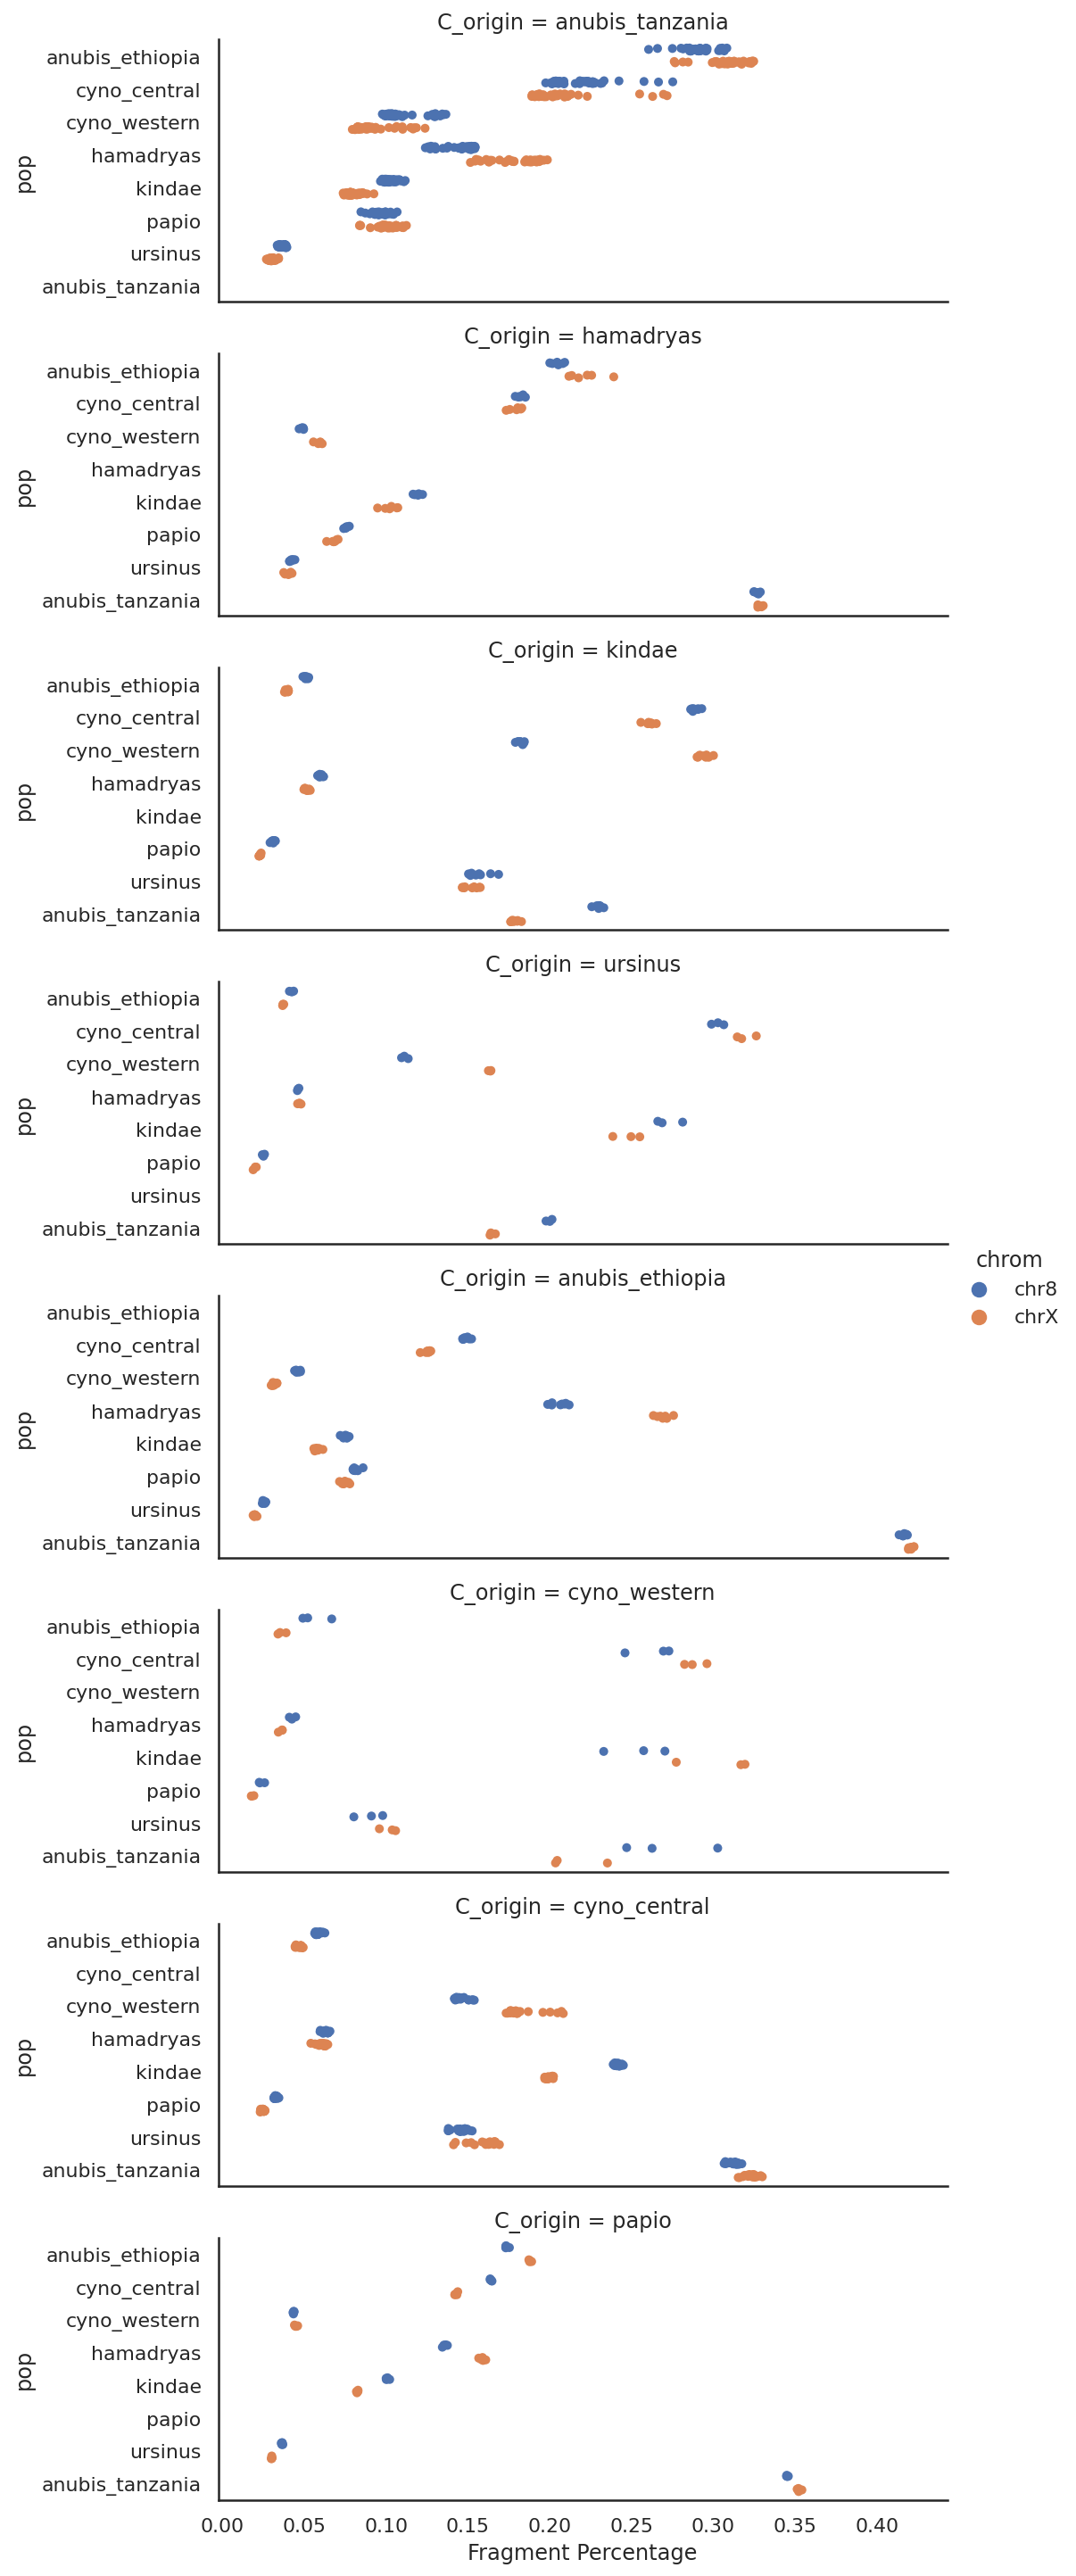

In [47]:
g = sns.catplot(data=df_length_stats, x="Fragment Percentage", y="pop", hue="chrom", kind="strip", orient="h",
                height=2.5, aspect=3, row="C_origin", dodge=True)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the fut

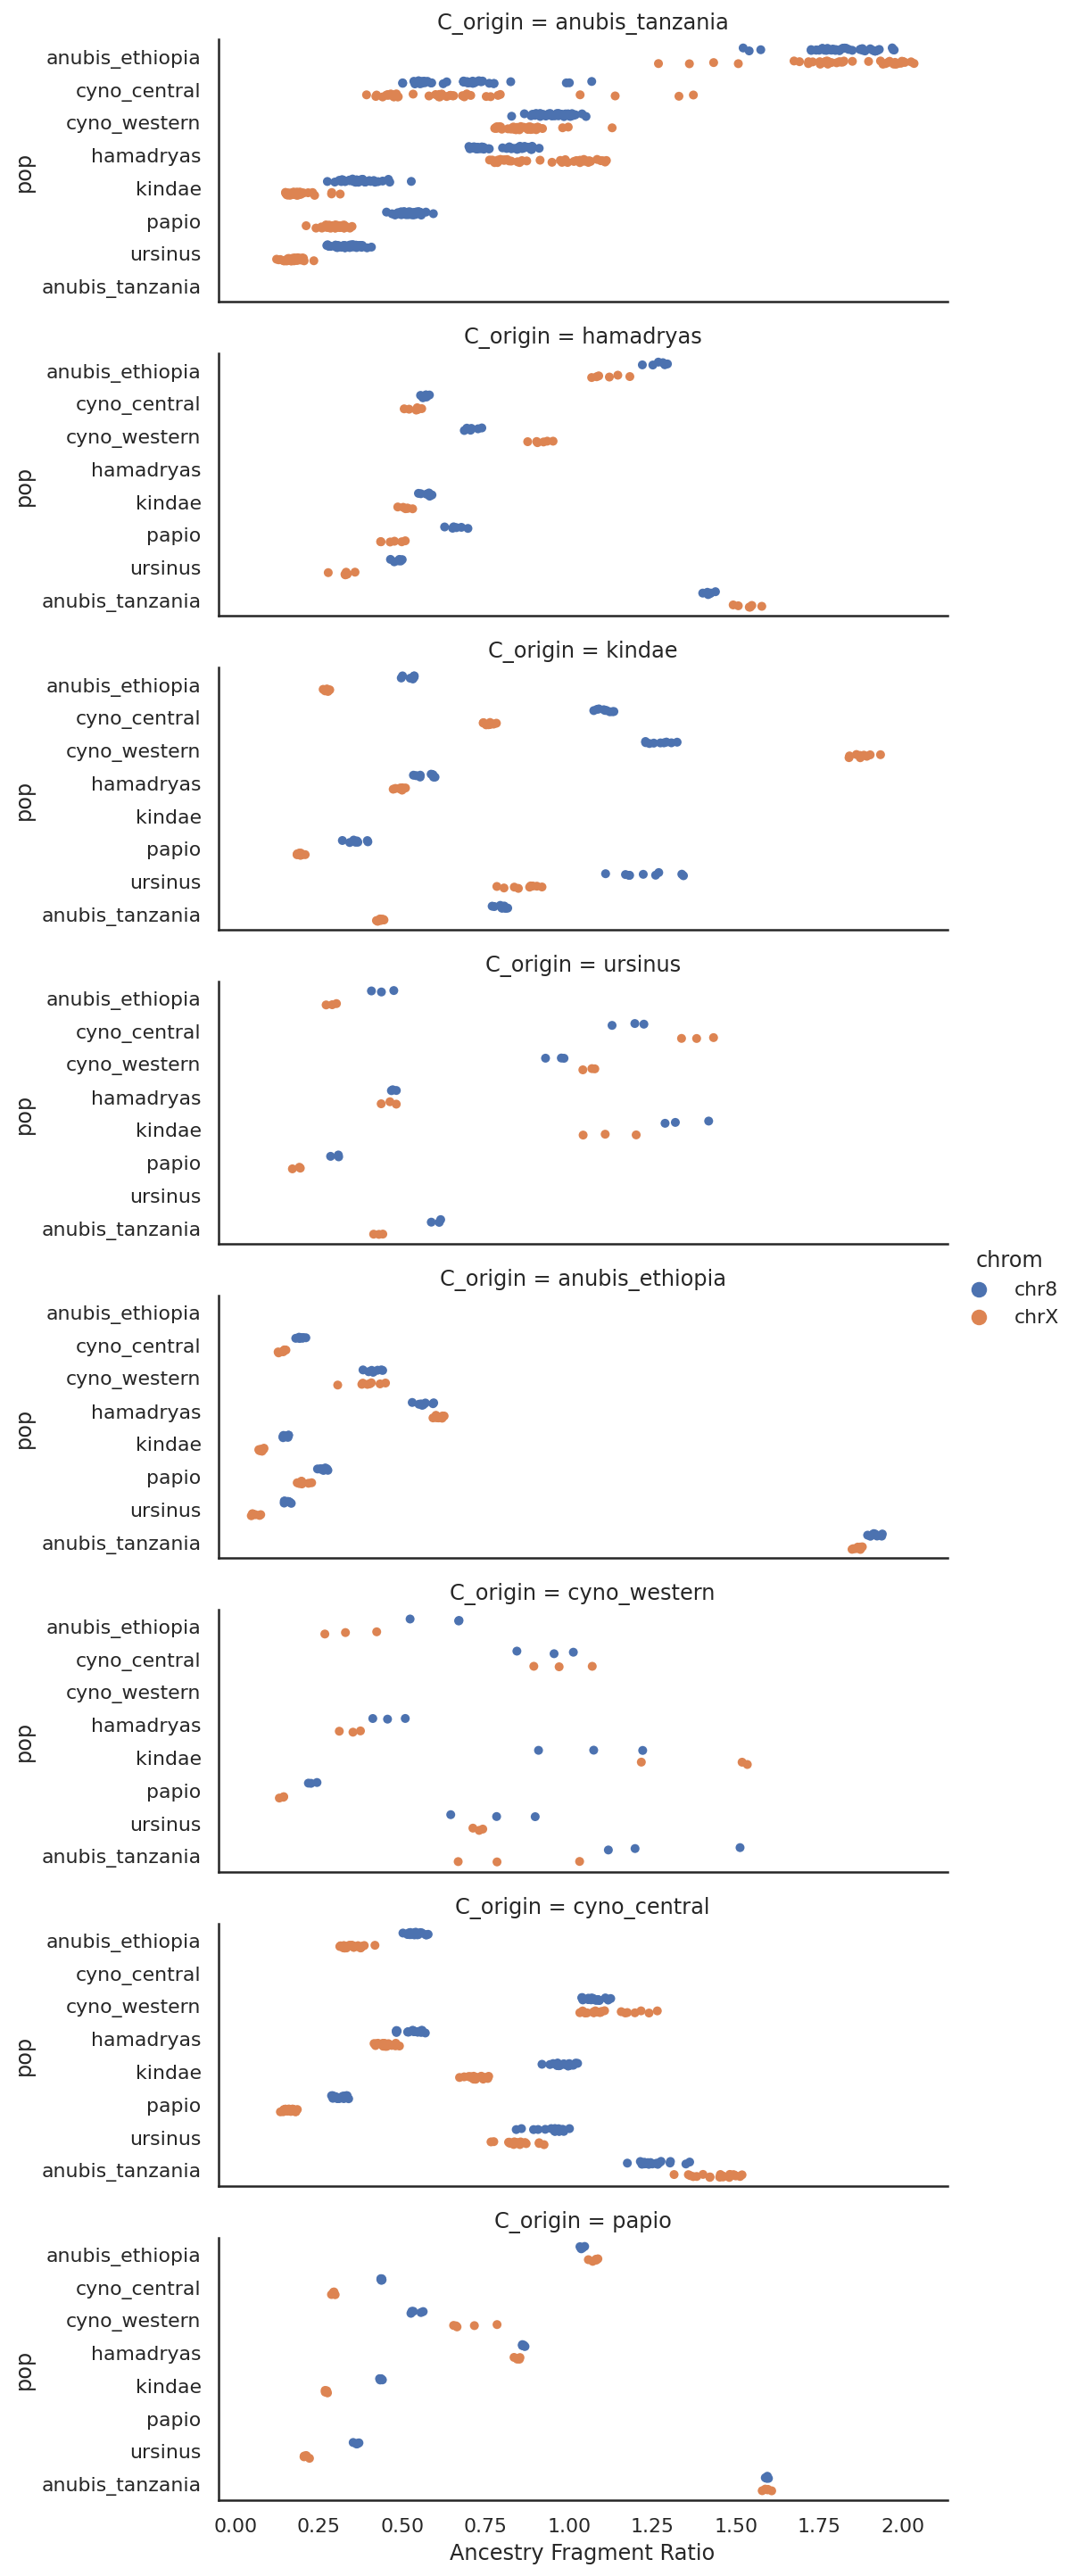

In [48]:
g = sns.catplot(data=df_length_stats, x="Ancestry Fragment Ratio", y="pop", hue="chrom", kind="strip", orient="h",
                height=2.5, aspect=3, row="C_origin", dodge=True)

In [49]:
df_length_stats = df_length_stats.sort_values(["Population, Recipient", "Population, Donor", "individual"])

In [50]:
df_length_stats.to_csv("../results/length_stats_8_cluster.txt", index=False)

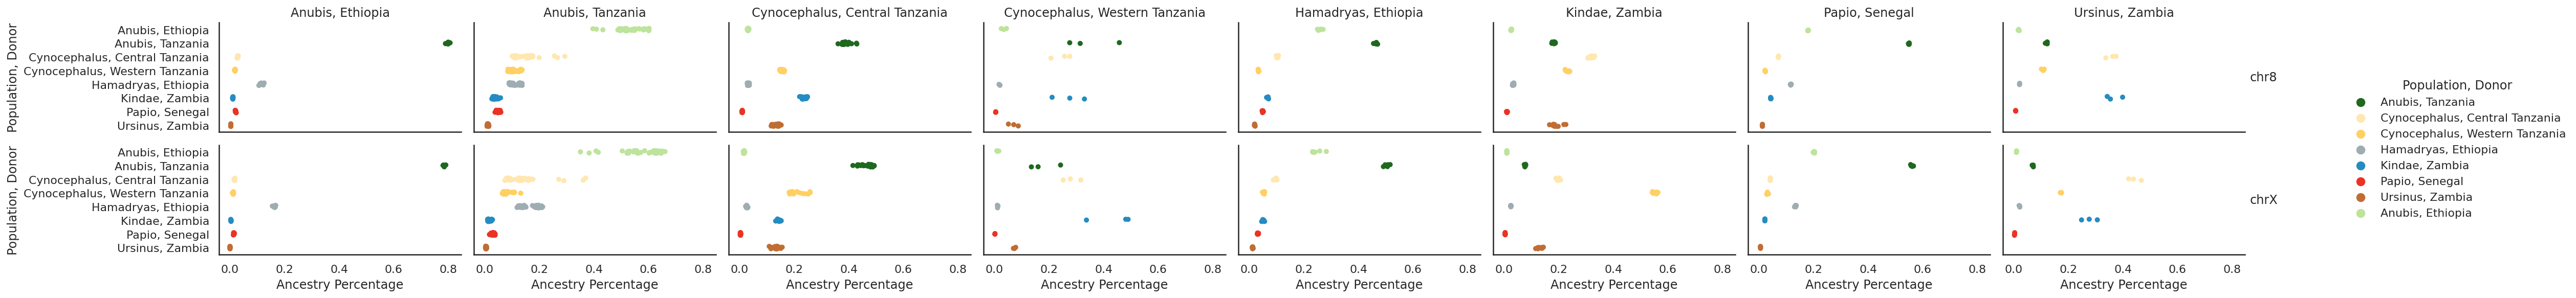

In [64]:
g = sns.catplot(data=df_length_stats, x="Ancestry Percentage", y="Population, Donor", hue="Population, Donor",
                palette=color_dir, kind="strip", height=2, aspect=2, col="Population, Recipient", row="chrom",
                jitter=True, edgecolor="black", order=sorted(df_length_stats["Population, Donor"].unique()),
                margin_titles=True)
for ax in g.axes.flat:
    plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
for ax in g.axes.flat:
    plt.setp(ax.texts, rotation="0")
plt.savefig("../figures/baboon_ancestry/ancestry_8pop.pdf", dpi=300, bbox_inches='tight')

Histograms of length distributions

In [21]:
test_df = df_lengths.loc[df_lengths.C_origin == "ursinus"]

In [22]:
df_8 = df_lengths.loc[df_lengths.chrom == "chr8"]
df_X = df_lengths.loc[df_lengths.chrom == "chrX"]

In [65]:
def move_legend(ax, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), title=title, **kws)

In [66]:
df_lengths["population"] = df_lengths["individual"].map(mapping)
df_lengths["Population, Donor"] = df_lengths["pop"].map(c_mapping)
df_lengths["Population, Recipient"] = df_lengths["C_origin"].map(c_mapping)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/distributions.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


[None]

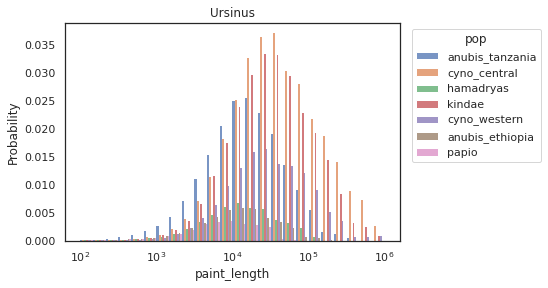

In [25]:
g = sns.histplot(test_df, x="paint_length", hue="pop", multiple="dodge", weights="paint_length",
                 stat="probability", bins=np.logspace(np.log10(100),np.log10(1000000), 25))
move_legend(g)
g.set(title="Ursinus")
g.set(xscale="log")
#bins=np.logspace(np.log10(100),np.log10(1000000), 25)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/distributions.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/distributions.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/distributions.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/distributions.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform 

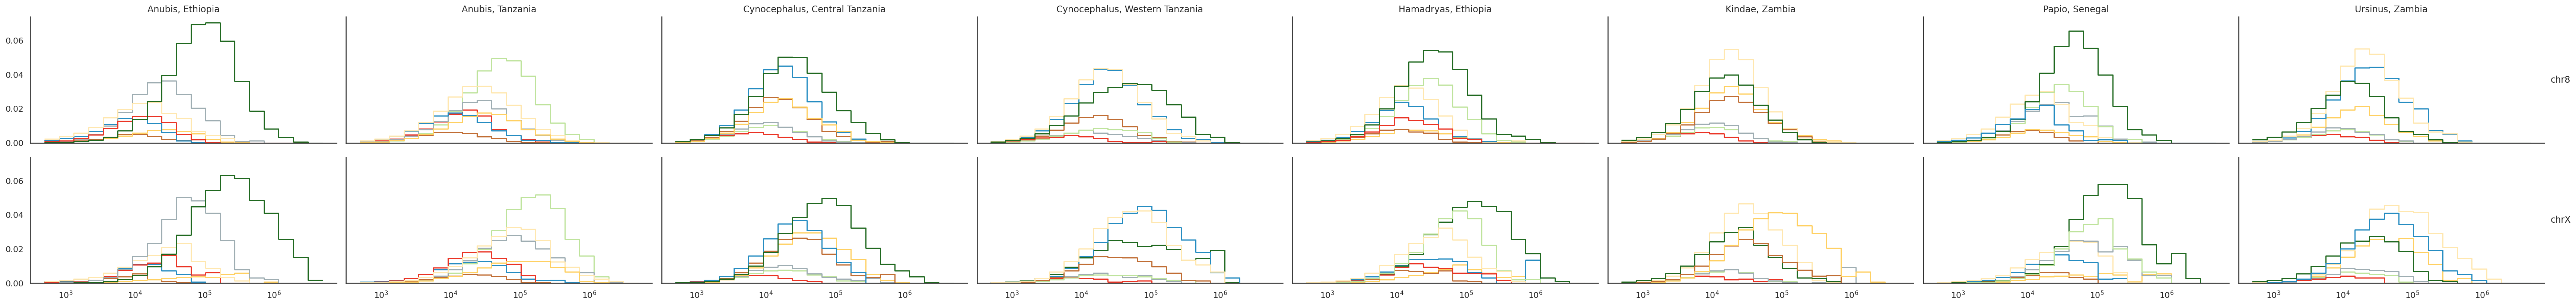

In [69]:
g = sns.FacetGrid(data=df_lengths, col="Population, Recipient", row="chrom", aspect=2, margin_titles=True)
g.map_dataframe(sns.histplot, x="paint_length", hue="Population, Donor", weights="paint_length",
                 stat="probability", bins=np.logspace(np.log10(500),np.log10(5000000), 20), palette=color_dir,
                 element="step", fill=False)
g.set(xscale="log")
for ax in g.axes.flat:
    plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
for ax in g.axes.flat:
    plt.setp(ax.texts, rotation="0")
plt.savefig("../figures/baboon_ancestry/paint_lengths_8pop.pdf", dpi=300, bbox_inches='tight')

In [70]:
for C_origin in []: #df_lengths.C_origin.unique():
    plt.clf()
    df_s = df_lengths.loc[df_lengths.C_origin == C_origin]
    g = sns.histplot(df_s, x="paint_length", hue="pop", multiple="dodge", weights="paint_length",
                 stat="probability", bins=np.logspace(np.log10(100),np.log10(2000000), 20),
                    palette=color_dir)
    move_legend(g)
    g.set(title=C_origin)
    g.set(xscale="log")
    g.set(xlabel = "Fragment size")
    g.set(ylabel = "Coverage")
    plt.savefig("../figures/baboon_histograms/{}_hist.png".format(C_origin))
    print(C_origin)

Going onto the 7 cluster analysis.

In [2]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_7_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"

os.makedirs("../steps/paint_summary/", exist_ok=True)
chrom_list = [] #["8", "X"] # ["X"]
window_length = 100000
df_l = []
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in ["cyno_anubis_t"]:
        print(population)
        pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "chr{}_7_cluster_large/{}_chr{}_7_cluster_large/chr{}.samples.out"\
                        .format(chrom, population, chrom, chrom)
        length_df = create_paint_df_lengths(pop_path, idfile)
        length_df["chrom"] = chrom
        length_df["C_origin"] = population
        df_l.append(length_df)
#df_lengths_7 = pd.concat(df_l)

In [3]:
#df_lengths_7.to_csv("../steps/paint_summary/"+"paint_lengths_7_cluster.txt", sep=" ", index=False)
df_lengths_7 = pd.read_csv("../steps/paint_summary/"+"paint_lengths_7_cluster.txt", sep=" ")

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Transformations to rename columns and calculate mean ancestry

In [4]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
c_mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
        c_mapping["Sci_"+row.PGDP_ID] = row.C_origin
    else:
        mapping[row.PGDP_ID] = row.Origin
        c_mapping[row.PGDP_ID] = row.C_origin
df_lengths_7["population"] = df_lengths_7["individual"].map(mapping)
df_lengths_7["C_origin"] = df_lengths_7["individual"].map(c_mapping)
df_lengths_7["chrom"] = ["chr{}".format(x) if str(x)[0] != "c" else x for x in df_lengths_7.chrom]

In [5]:
id_mapping = {}
for donor in idfile["pop"].unique():
    IDs = idfile.loc[idfile["pop"] == donor].PGDP_ID.unique()
    id_mapping[donor] = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(IDs)].C_origin.unique()[0]

In [50]:
df_length_stats_7 = df_lengths_7.groupby(["individual", "pop", "C_origin", "chrom"]).sum().reset_index()
df_length_stats_7["Ancestry Counts"] = (df_length_stats_7.groupby(["individual", "pop", "C_origin", "chrom"]).count().reset_index()).paint_length
df_length_stats_7["Mean Fragment"] = (df_length_stats_7.groupby(["individual", "pop", "C_origin", "chrom"]).mean().reset_index()).paint_length

In [51]:
groups = df_length_stats_7.groupby(["individual", "chrom"])
s = groups.transform("sum")
df_length_stats_7["Ancestry Percentage"] = df_length_stats_7["paint_length"]/s["paint_length"]
df_length_stats_7["Fragment Percentage"] = df_length_stats_7["Ancestry Counts"]/s["Ancestry Counts"]

In [52]:
df_length_stats_7["population"] = df_length_stats_7["individual"].map(mapping)
df_length_stats_7["Population, Donor"] = df_length_stats_7["pop"].map(id_mapping)
df_length_stats_7["Population, Recipient"] = df_length_stats_7["individual"].map(c_mapping)
df_length_stats_7 = df_length_stats_7.sort_values(["population", "individual", "pop"])
df_length_stats_7["Ancestry Fragment Ratio"] = df_length_stats_7["Ancestry Percentage"]/df_length_stats_7["Fragment Percentage"]

In [53]:
df_length_stats_8 = pd.read_csv("../results/length_stats_8_cluster.txt")

In [54]:
mycols = sns.color_palette(["#BEE39C", "#1F681F", "#FFE7AF",
                            "#FFD062", "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])
name_order = sorted(df_length_stats_8["Population, Donor"].unique())
color_dir = {}
for i in range(len(name_order)):
    color_dir[name_order[i]] = mycols[i]
# This order of color is based on the alphabetical ordering of the 14 clusters
mycols_cmap = ListedColormap(mycols.as_hex())
mycols

[(0.7450980392156863, 0.8901960784313725, 0.611764705882353),
 (0.12156862745098039, 0.40784313725490196, 0.12156862745098039),
 (1.0, 0.9058823529411765, 0.6862745098039216),
 (1.0, 0.8156862745098039, 0.3843137254901961),
 (0.6196078431372549, 0.6784313725490196, 0.6980392156862745),
 (0.1450980392156863, 0.5490196078431373, 0.7568627450980392),
 (0.9176470588235294, 0.2, 0.1411764705882353),
 (0.7529411764705882, 0.42745098039215684, 0.20392156862745098)]

In [55]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
idfile_8 = idfile.loc[idfile.PGDP_ID.isin(df_length_stats_8.individual)]
color_8 = sns.color_palette(["#BEE39C", "#1F681F", "#FFE7AF",
                            "#FFD062", "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])

name_order = ['Gog olive', 'Tanzanian olive',
       'Eastern Tanzania yellow', 'Western Tanzania yellow',
       'Hamadryas', 'Kinda', 'Guinea',
       'Chacma']
i_order = sorted(df_length_stats_8["Population, Recipient"].unique())
p_map = {}
for i in range(len(i_order)):
    p_map[i_order[i]] = name_order[i]
l_list = sorted(idfile_8["pop"].unique())
dict_8 = {}
color_dir = {}
for i in range(len(l_list)):
    dict_8[l_list[i]] = name_order[i]
    color_dir[name_order[i]] = color_8[i]

In [56]:
df_length_stats_8["Population, Donor"] = df_length_stats_8["Population, Donor"].map(p_map)
df_length_stats_8["Population, Recipient"] = df_length_stats_8["Population, Recipient"].map(p_map)
df_length_stats_7["Population, Donor"] = df_length_stats_7["Population, Donor"].map(p_map)
df_length_stats_7["Population, Recipient"] = df_length_stats_7["Population, Recipient"].map(p_map)

In [32]:
df_length_stats_8_ac = df_length_stats_8.loc[(df_length_stats_8.C_origin == "anubis_tanzania")
                                             | (df_length_stats_8.C_origin == "cyno_central")]

In [33]:
df_length_stats_8_ac.to_csv("../results/length_stats_8_cluster_ac.txt", index=False)

In [69]:
df_length_stats_8_ac

,individual,pop,C_origin,chrom,pos,paint,paint_length,end_pos,haplotype,Ancestry Counts,Mean Fragment,Ancestry Percentage,Fragment Percentage,population,"Population, Donor","Population, Recipient",Ancestry Fragment Ratio
112,PD_0199,anubis_ethiopia,anubis_tanzania,chr8,4419927660257,10543755,1689796360,4421617390093,91684,66524,25401.304191,0.602027,0.305526,"Serengeti, Tanzania",Gog olive,Tanzanian olive,1.970460
113,PD_0199,anubis_ethiopia,anubis_tanzania,chrX,2082066802459,4423307,1825054225,2083891828762,38586,27922,65362.589535,0.646304,0.324151,"Serengeti, Tanzania",Gog olive,Tanzanian olive,1.993840
114,PD_0200,anubis_ethiopia,anubis_tanzania,chr8,4451442706655,10701360,1664128520,4453106767626,93011,67549,24635.872034,0.592882,0.308281,"Serengeti, Tanzania",Gog olive,Tanzanian olive,1.923187
115,PD_0200,anubis_ethiopia,anubis_tanzania,chrX,2135506119912,4539600,1792243356,2137298334612,39844,28656,62543.389028,0.634685,0.323852,"Serengeti, Tanzania",Gog olive,Tanzanian olive,1.959803
116,PD_0203,anubis_ethiopia,anubis_tanzania,chr8,4435497490534,10721758,1686668491,4437184091334,92837,67691,24917.174972,0.600912,0.304480,"Serengeti, Tanzania",Gog olive,Tanzanian olive,1.973571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,PD_0774,ursinus,cyno_central,chrX,1829232610690,3551992,392081481,1829624666374,37206,25797,15198.723921,0.138847,0.162473,"Mikumi, Tanzania",Chacma,Eastern Tanzania yellow,0.854587
1004,Sci_16066,ursinus,cyno_central,chr8,3135684442757,6795913,395580491,3136079973842,67408,49406,8006.729770,0.140934,0.145233,"Mikumi, Tanzania",Chacma,Eastern Tanzania yellow,0.970399
1005,Sci_16066,ursinus,cyno_central,chrX,1834082198389,3564205,390975141,1834473147647,37229,25883,15105.480083,0.138456,0.163480,"Mikumi, Tanzania",Chacma,Eastern Tanzania yellow,0.846926
1006,Sci_16098,ursinus,cyno_central,chr8,3196708334110,6933785,397451298,3197105734985,68544,50423,7882.341352,0.141601,0.147907,"Mikumi, Tanzania",Chacma,Eastern Tanzania yellow,0.957365


/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


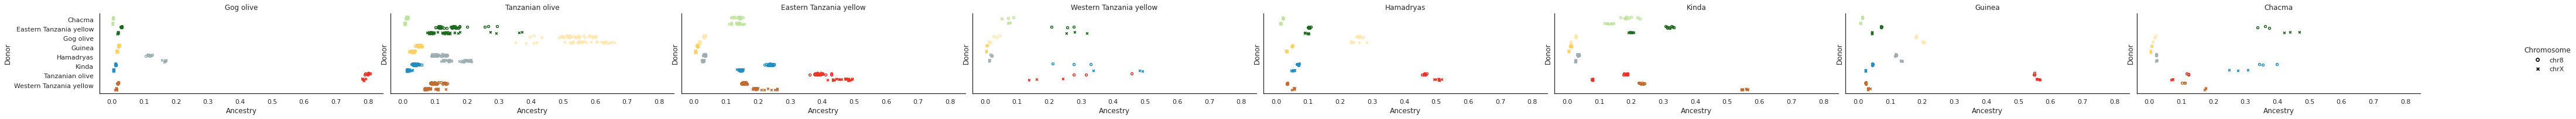

In [72]:
input_data = df_length_stats_8
input_data.chrom = input_data.chrom.astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].astype("category")

def fun(a, b, markercat, markers, jitter=0.2, dodge=0.3, label=None, data=None, **kwargs):
    offsets = dict((zip(data[markercat].cat.categories, np.linspace(-1, 1, len(data[markercat].cat.categories)))))
    colors = dict(zip(data[b].cat.categories.values, sns.color_palette()))    
    ax = sns.stripplot(x=data[a], y=data[b], 
                       palette=sns.color_palette(['white']),
                      )
    for name, group in data.groupby(b):
        sc = plt.scatter(group[a], np.array(
                        group[b].cat.codes.values) + \
                        jitter*np.random.random(size=len(group[b].cat.codes.values)) + \
                        offsets[label]*dodge, 
                    color=colors[name],
                    marker=markers[label], zorder=10, s=20)

palette_subset = {key: color_dir[key] for key in name_order}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data,
                      margin_titles=True, legend_out=True, aspect=2.5, row_order=name_order)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    # axix labels and rotated labels (this has to be in a separate for-loop)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")

    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.savefig("../figures/baboon_ancestry/ancestry_tanzania_8pop.png", dpi=300, bbox_inches='tight')

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


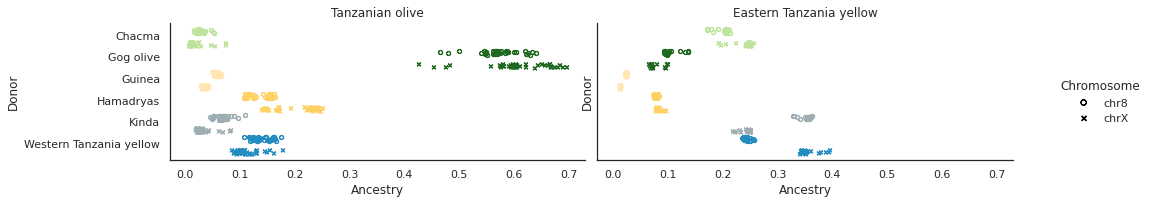

In [64]:
input_data = df_length_stats_7
input_data.chrom = input_data.chrom.astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].astype("category")

palette_subset = {key: color_dir[key] for key in name_order}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data,
                      margin_titles=True, legend_out=True, aspect=2.5)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    # axix labels and rotated labels (this has to be in a separate for-loop)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")

    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.savefig("../figures/baboon_ancestry/ancestry_tanzania_7pop.png", dpi=300, bbox_inches='tight')

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


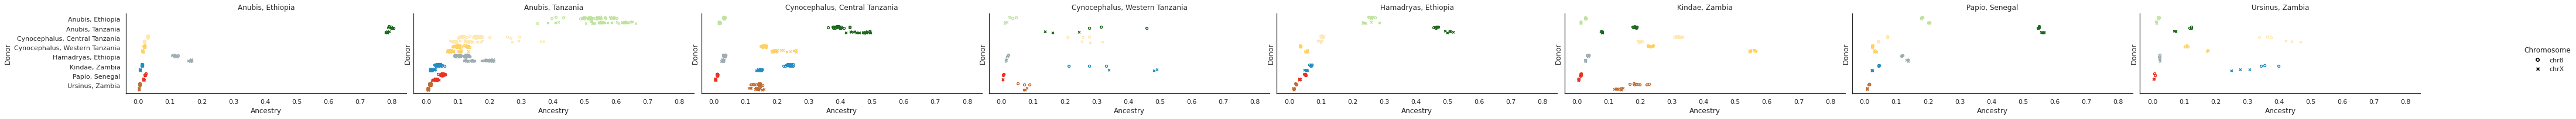

In [66]:
input_data = df_length_stats_8
input_data.chrom = input_data.chrom.astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].astype("category")

palette_subset = {key: color_dir[key] for key in sorted(input_data["Population, Donor"].unique())}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data,
                      margin_titles=True, legend_out=True, aspect=2.5)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    # axix labels and rotated labels (this has to be in a separate for-loop)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")

    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.savefig("../figures/baboon_ancestry/ancestry_8pop.png", dpi=300, bbox_inches='tight')

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some i

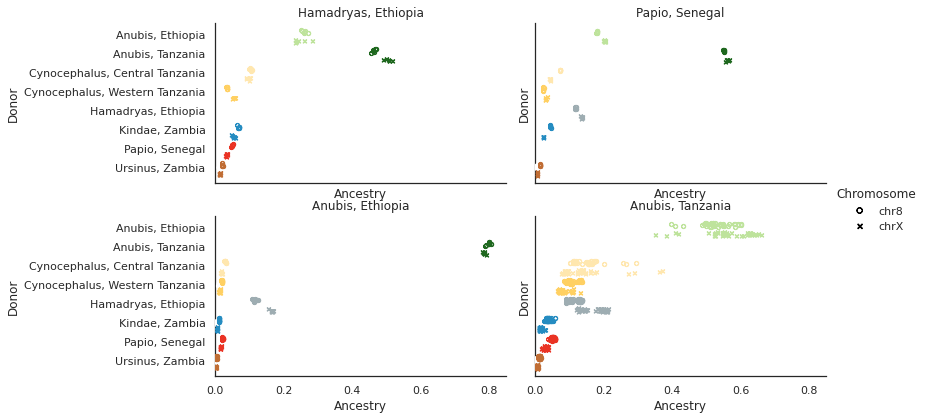

In [42]:
north = ['Hamadryas, Ethiopia', 'Papio, Senegal', 'Anubis, Ethiopia', 'Anubis, Tanzania']
input_data = df_length_stats_8.loc[df_length_stats_8["Population, Recipient"].isin(north)]
input_data.chrom = input_data.chrom.astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].astype("category")

palette_subset = {key: color_dir[key] for key in sorted(input_data["Population, Donor"].unique())}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data,
                      margin_titles=True, legend_out=True, aspect=2, col_wrap=2, col_order=north)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.set(xlim=(0, 0.85))
    # axix labels and rotated labels (this has to be in a separate for-loop)
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")
    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.savefig("../figures/baboon_ancestry/ancestry_8pop_north.png", dpi=300, bbox_inches='tight')

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend

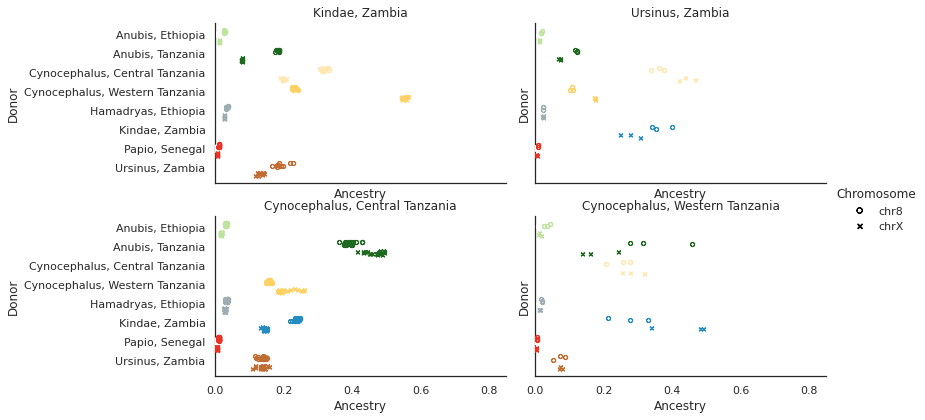

In [43]:
south = ['Kindae, Zambia', 'Ursinus, Zambia',
         'Cynocephalus, Central Tanzania', 'Cynocephalus, Western Tanzania']
input_data = df_length_stats_8.loc[df_length_stats_8["Population, Recipient"].isin(south)]
input_data.chrom = input_data.chrom.astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].astype("category")

palette_subset = {key: color_dir[key] for key in sorted(input_data["Population, Donor"].unique())}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data,
                      margin_titles=True, legend_out=True, aspect=2, col_wrap=2, col_order=south)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.set(xlim=(0, 0.85))
    # axix labels and rotated labels (this has to be in a separate for-loop)
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")
    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.savefig("../figures/baboon_ancestry/ancestry_8pop_south.png", dpi=300, bbox_inches='tight')

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


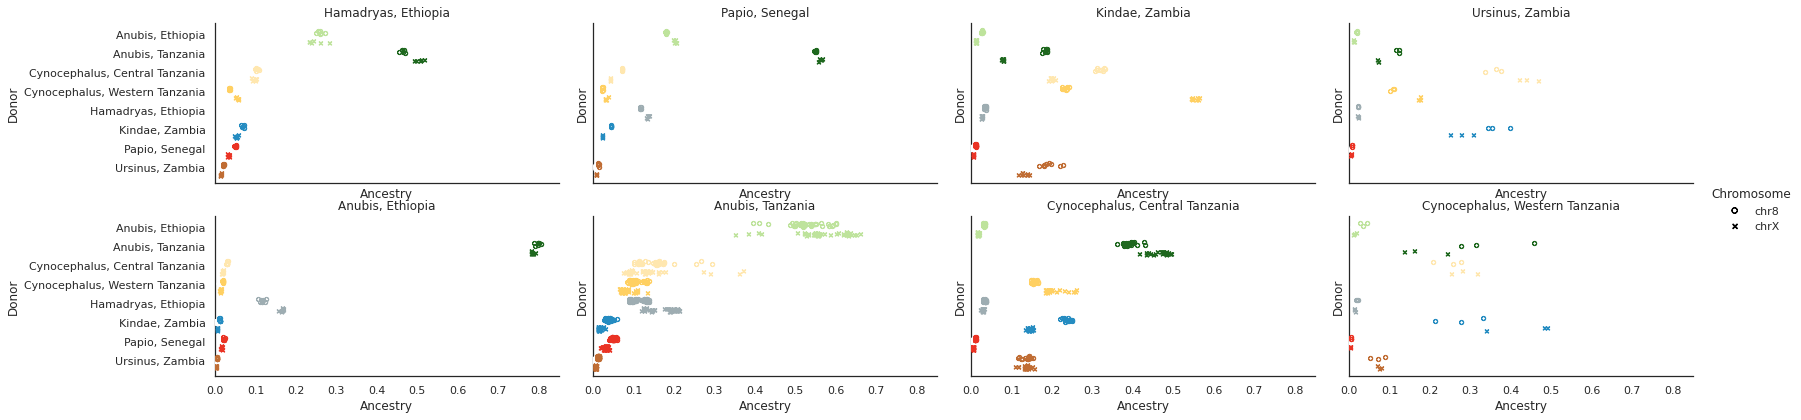

In [44]:
order_all = ['Hamadryas, Ethiopia', 'Papio, Senegal','Kindae, Zambia', 'Ursinus, Zambia',
         'Anubis, Ethiopia', 'Anubis, Tanzania', 'Cynocephalus, Central Tanzania', 'Cynocephalus, Western Tanzania']
 
input_data = df_length_stats_8.loc[df_length_stats_8["Population, Recipient"].isin(order_all)]
input_data.chrom = input_data.chrom.astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].astype("category")

palette_subset = {key: color_dir[key] for key in sorted(input_data["Population, Donor"].unique())}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data,
                      margin_titles=True, legend_out=True, height=3, aspect=2, col_wrap=4, col_order=order_all)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.set(xlim=(0, 0.85))
    # axix labels and rotated labels (this has to be in a separate for-loop)
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")
    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.savefig("../figures/baboon_ancestry/ancestry_8pop_all.png", dpi=300, bbox_inches='tight')

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

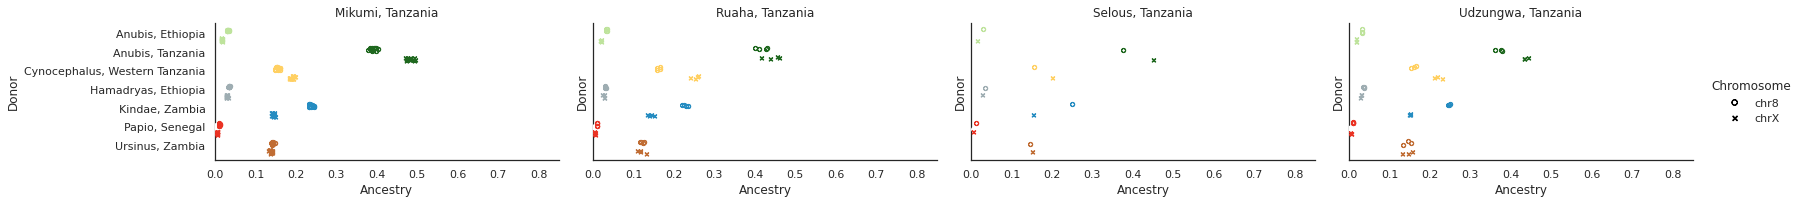

In [90]:
order_all = ['Cynocephalus, Central Tanzania']
 
input_data_sub = (df_length_stats_8_ac.loc[df_length_stats_8_ac["Population, Recipient"].isin(order_all)])
input_data_sub.chrom = input_data_sub.chrom.astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].astype("category")
input_data_sub["Population, Location"] = input_data_sub["population"].astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].cat.remove_unused_categories()

palette_subset = {key: color_dir[key] for key in sorted(input_data["Population, Donor"].unique())}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Location", hue="chrom", data=input_data_sub,
                      margin_titles=True, legend_out=True, height=3, aspect=2, col_wrap=4)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.set(xlim=(0, 0.85))
    # axix labels and rotated labels (this has to be in a separate for-loop)
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")
    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.savefig("../figures/baboon_ancestry/ancestry_8pop_cyno_samples.png", dpi=300, bbox_inches='tight')

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

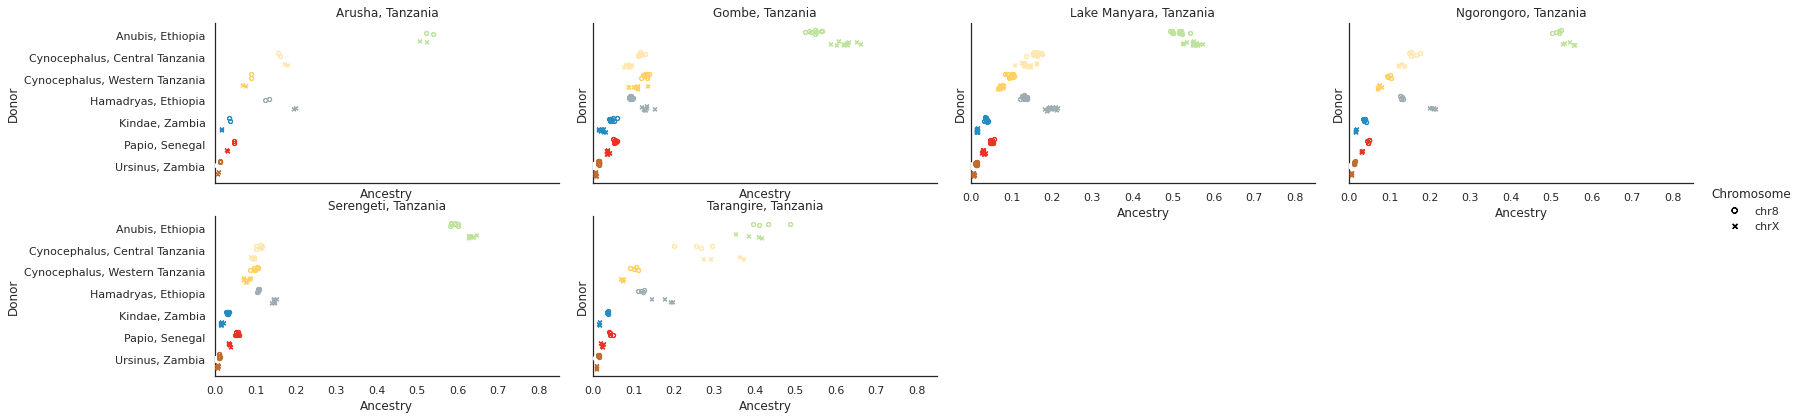

In [93]:
order_all = ['Anubis, Tanzania']
 
input_data_sub = (df_length_stats_8_ac.loc[df_length_stats_8_ac["Population, Recipient"].isin(order_all)])
input_data_sub.chrom = input_data_sub.chrom.astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].astype("category")
input_data_sub["Population, Location"] = input_data_sub["population"].astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].cat.remove_unused_categories()

palette_subset = {key: color_dir[key] for key in sorted(input_data_sub["Population, Donor"].unique())}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Location", hue="chrom", data=input_data_sub,
                      margin_titles=True, legend_out=True, height=3, aspect=2, col_wrap=4)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.set(xlim=(0, 0.85))
    # axix labels and rotated labels (this has to be in a separate for-loop)
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")
    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.savefig("../figures/baboon_ancestry/ancestry_8pop_anubis_samples.png", dpi=300, bbox_inches='tight')

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


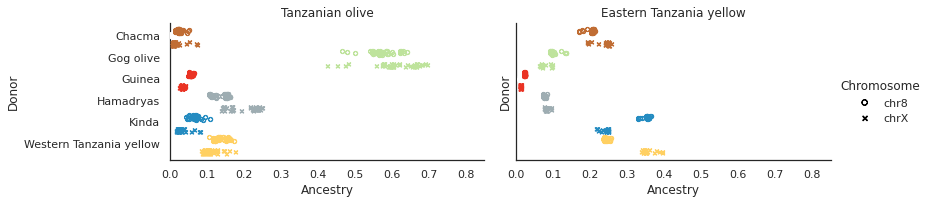

In [74]:
input_data = df_length_stats_7
input_data.chrom = input_data.chrom.astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].astype("category")

palette_subset = {key: color_dir[key] for key in sorted(input_data["Population, Donor"].unique())}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data,
                      margin_titles=True, legend_out=True, height=3, aspect=2, col_wrap=2)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.set(xlim=(0, 0.85))
    # axix labels and rotated labels (this has to be in a separate for-loop)
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")
    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.savefig("../figures/baboon_ancestry/ancestry_tanzania_7pop.png", dpi=300, bbox_inches='tight')

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

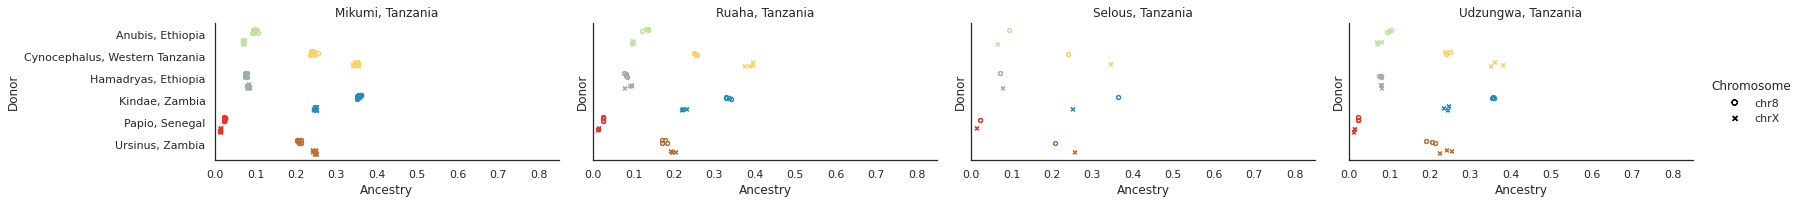

In [95]:
order_all = ['Cynocephalus, Central Tanzania']
 
input_data_sub = (df_length_stats_7.loc[df_length_stats_7["Population, Recipient"].isin(order_all)])
input_data_sub.chrom = input_data_sub.chrom.astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].astype("category")
input_data_sub["Population, Location"] = input_data_sub["population"].astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].cat.remove_unused_categories()

palette_subset = {key: color_dir[key] for key in sorted(input_data_sub["Population, Donor"].unique())}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Location", hue="chrom", data=input_data_sub,
                      margin_titles=True, legend_out=True, height=3, aspect=2, col_wrap=4)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.set(xlim=(0, 0.85))
    # axix labels and rotated labels (this has to be in a separate for-loop)
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")
    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.savefig("../figures/baboon_ancestry/ancestry_7pop_cyno_samples.png", dpi=300, bbox_inches='tight')

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

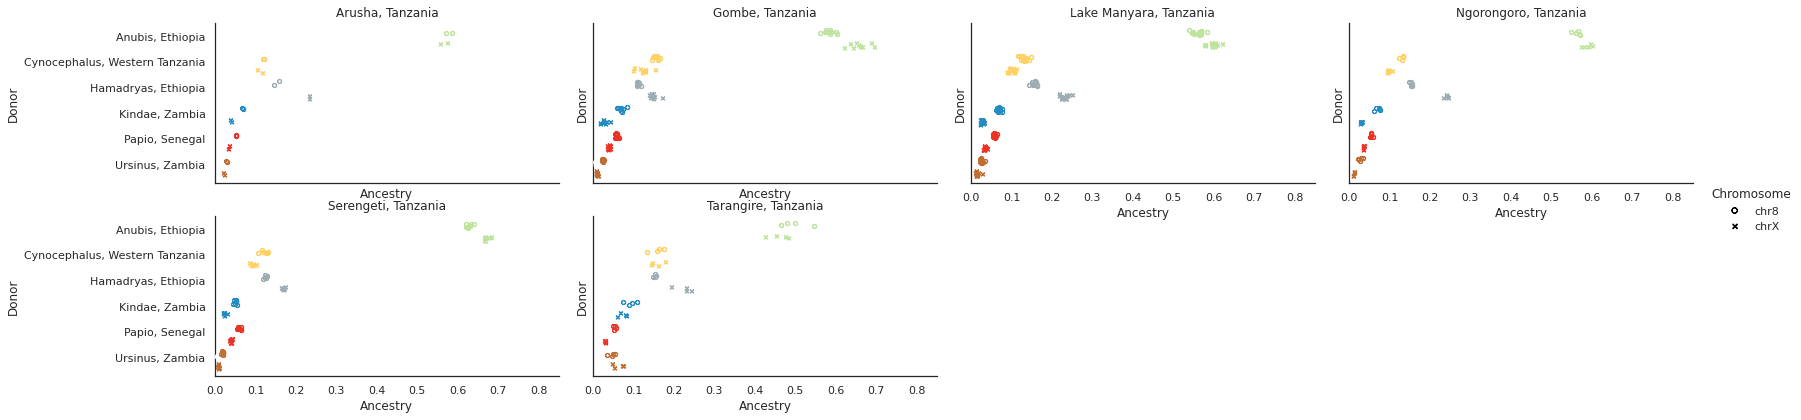

In [94]:
order_all = ['Anubis, Tanzania']
 
input_data_sub = (df_length_stats_7.loc[df_length_stats_7["Population, Recipient"].isin(order_all)])
input_data_sub.chrom = input_data_sub.chrom.astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].astype("category")
input_data_sub["Population, Location"] = input_data_sub["population"].astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].cat.remove_unused_categories()

palette_subset = {key: color_dir[key] for key in sorted(input_data_sub["Population, Donor"].unique())}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Location", hue="chrom", data=input_data_sub,
                      margin_titles=True, legend_out=True, height=3, aspect=2, col_wrap=4)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.set(xlim=(0, 0.85))
    # axix labels and rotated labels (this has to be in a separate for-loop)
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")
    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.savefig("../figures/baboon_ancestry/ancestry_7pop_anubis_samples.png", dpi=300, bbox_inches='tight')

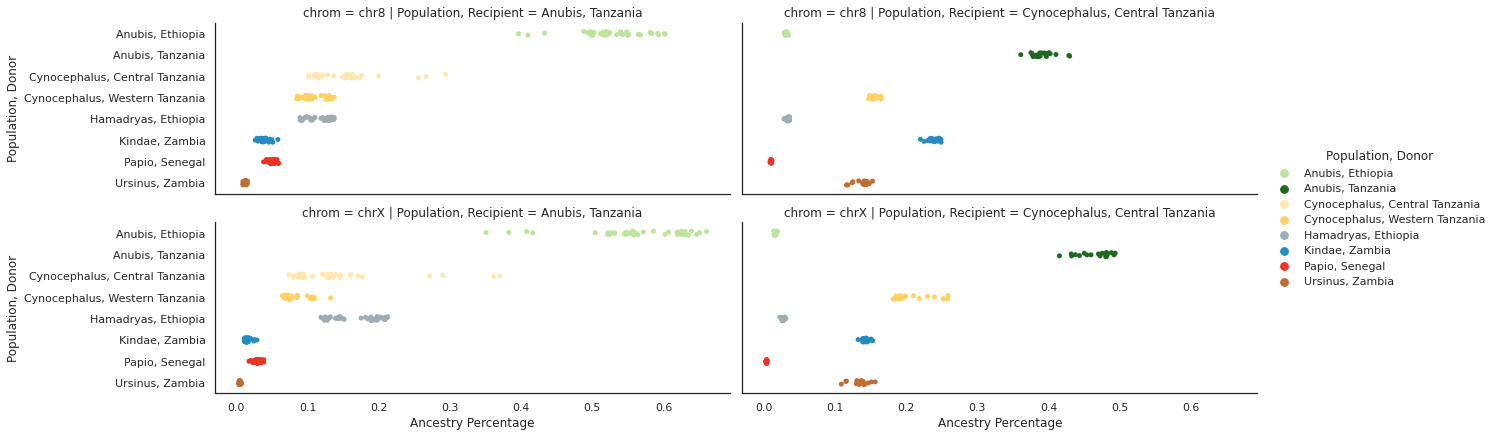

In [21]:
g = sns.catplot(data=df_length_stats_8_ac, x="Ancestry Percentage", y="Population, Donor", hue="Population, Donor",
                palette=color_dir, kind="strip", orient="h", height=3, aspect=3, col="Population, Recipient", row="chrom",
                jitter=True, edgecolor="gray", order=sorted(df_length_stats_8_ac["Population, Donor"].unique()),
                facet_kws=dict(sharex=True, sharey=True, margin_titles=True))

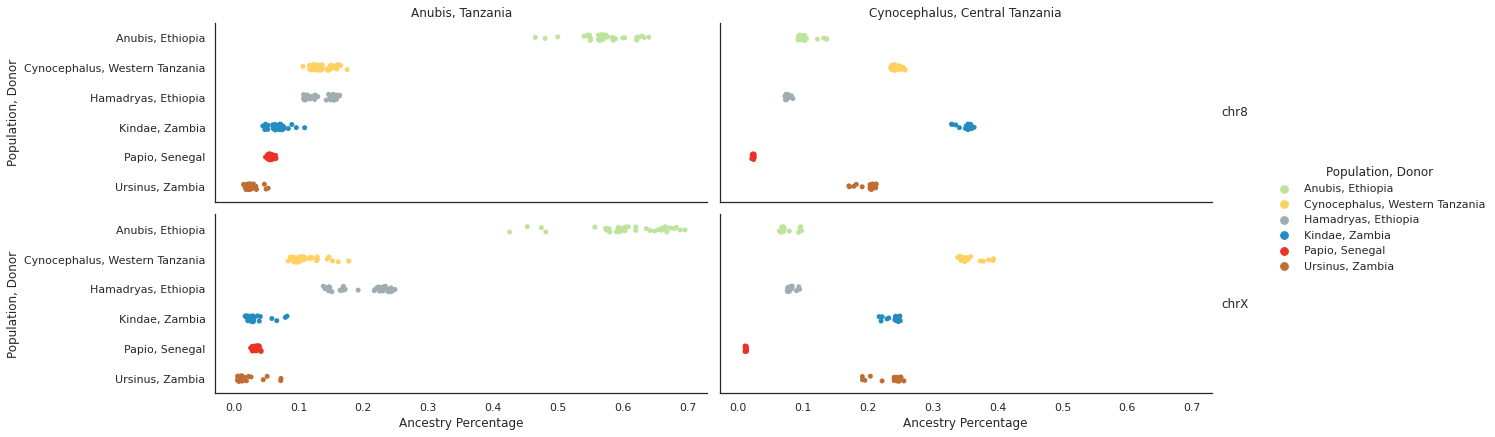

In [22]:
g = sns.catplot(data=df_length_stats_7, x="Ancestry Percentage", y="Population, Donor", hue="Population, Donor",
                palette=color_dir, kind="strip", orient="h", height=3, aspect=3, col="Population, Recipient", row="chrom",
                jitter=True, edgecolor="gray", order=sorted(df_length_stats_7["Population, Donor"].unique()),
                margin_titles=True)
for ax in g.axes.flat:
    plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
for ax in g.axes.flat:
    plt.setp(ax.texts, rotation="0")
plt.savefig("../figures/baboon_ancestry/paint_lengths_7pop.pdf", dpi=300, bbox_inches='tight')

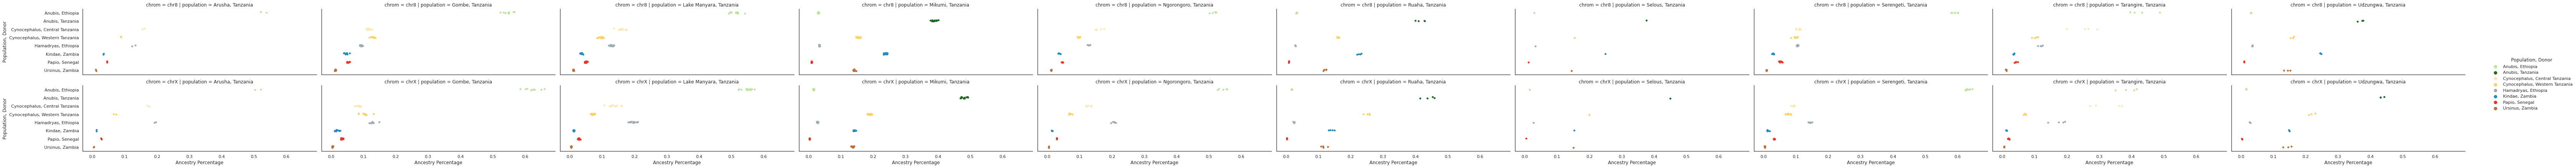

In [24]:
g = sns.catplot(data=df_length_stats_8_ac, x="Ancestry Percentage", y="Population, Donor", hue="Population, Donor",
                palette=color_dir, kind="strip", orient="h", height=3, aspect=3, col="population", row="chrom",
                jitter=True, edgecolor="gray", order=sorted(df_length_stats_8_ac["Population, Donor"].unique()),
                facet_kws=dict(sharex=True, sharey=True, margin_titles=True))

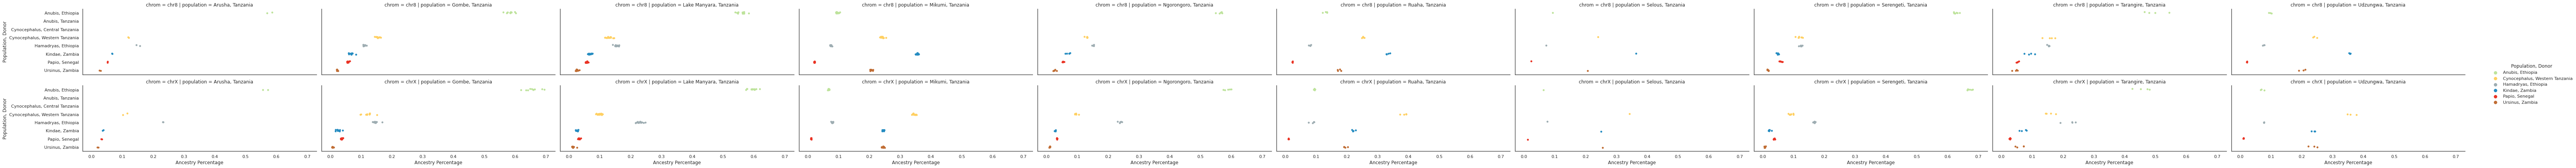

In [25]:
g = sns.catplot(data=df_length_stats_7, x="Ancestry Percentage", y="Population, Donor", hue="Population, Donor",
                palette=color_dir, kind="strip", orient="h", height=3, aspect=3, col="population", row="chrom",
                jitter=True, edgecolor="gray", order=sorted(df_length_stats_8_ac["Population, Donor"].unique()),
                facet_kws=dict(sharex=True, sharey=True, margin_titles=True))

Calculating some comparative statistics between 8 cluster and 7 cluster

In [23]:
#Potential way to calculate the normalization:
subset_df_at = df_length_stats_8_ac.loc[(df_length_stats_8_ac["Population, Recipient"] == "Anubis, Tanzania")
                                    & (df_length_stats_8_ac["Population, Donor"] != "Cynocephalus, Central Tanzania")]
groups = subset_df.groupby(["individual", "chrom"])
s = groups.transform("sum")
subset_df_at["Ancestry Percentage cleaned"] = subset_df_at["Ancestry Percentage"]/s["Ancestry Percentage"]

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
subset_df_cc = df_length_stats_8_ac.loc[(df_length_stats_8_ac["Population, Recipient"] == "Cynocephalus, Central Tanzania")
                                    & (df_length_stats_8_ac["Population, Donor"] != "Anubis, Tanzania")]
groups = subset_df.groupby(["individual", "chrom"])
s = groups.transform("sum")
subset_df_cc["Ancestry Percentage cleaned"] = subset_df_cc["Ancestry Percentage"]/s["Ancestry Percentage"]

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [25]:
subset_df = pd.concat([subset_df_at, subset_df_cc])

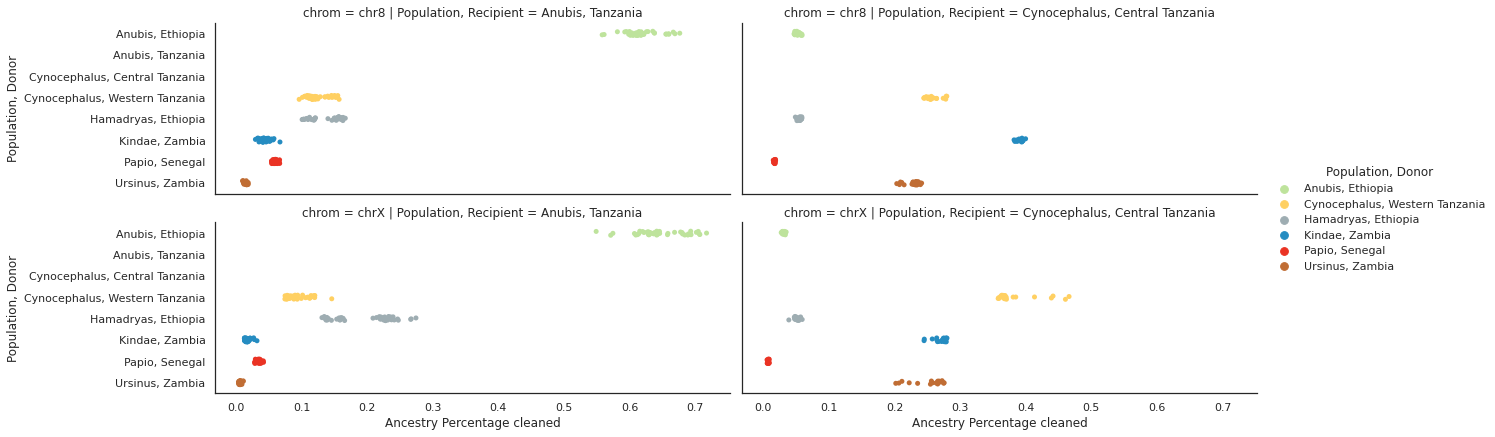

In [26]:
g = sns.catplot(data=subset_df, x="Ancestry Percentage cleaned", y="Population, Donor", hue="Population, Donor",
                palette=color_dir, kind="strip", orient="h", height=3, aspect=3, col="Population, Recipient", row="chrom",
                jitter=True, edgecolor="gray", order=sorted(df_length_stats_8_ac["Population, Donor"].unique()),
                facet_kws=dict(sharex=True, sharey=True, margin_titles=True))